In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import spacy
import pickle

nlp = spacy.load("en_core_web_sm")
from ast import literal_eval as le
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import warnings as w

w.filterwarnings("ignore")


stopwords_nltk = stopwords.words("english")
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS
stopwords = set(stopwords_nltk + list(stopwords_spacy))

In [2]:
df = pd.read_csv("anime_data.csv")
df.reset_index(inplace=True)
url_df = pd.read_csv("anime_url.csv")
url_df.reset_index(inplace=True)
pd.set_option("display.max_columns", None)
df = url_df.merge(df, on='index',how='left')
df.drop(['index'],axis=1,inplace=True)

pd.set_option("display.max_columns", None)

In [3]:
df

,anime_url,anime_poster,anime_title,anime_overview,anime_mal_score,anime_studio,anime_producer,anime_genres
0,https://aniwatchtv.to/bungaku-shoujo-kyou-no-o...,https://img.flawlessfiles.com/_r/300x400/100/5...,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",\n Shor...,6.92,Production I.G,"['Lantis', 'Pony Canyon', 'Enterbrain', 'Kadok...","['Comedy', 'Fantasy', 'School']"
1,https://aniwatchtv.to/bungaku-shoujo-memoire-2108,https://img.flawlessfiles.com/_r/300x400/100/e...,"""Bungaku Shoujo"" Memoire",\n Epis...,7.35,Production I.G,"['Lantis', 'Pony Canyon', 'Enterbrain', 'Kadok...","['Drama', 'Romance', 'School']"
2,https://aniwatchtv.to/bungaku-shoujo-movie-1802,https://img.flawlessfiles.com/_r/300x400/100/5...,"""Bungaku Shoujo"" Movie",\n The ...,7.43,Production I.G,"['Lantis', 'Pony Canyon', 'Enterbrain', 'Kadok...","['Mystery', 'Drama', 'Romance', 'School']"
3,https://aniwatchtv.to/my-star-18330,https://img.flawlessfiles.com/_r/300x400/100/9...,My Star,\n In t...,9.33,Doga Kobo,"['Kadokawa', 'Shueisha']","['Drama', 'Music', 'Supernatural', 'Seinen']"
4,https://aniwatchtv.to/hackgu-returner-4688,https://img.flawlessfiles.com/_r/300x400/100/e...,.hack//G.U. Returner,\n The ...,6.73,Bee Train,"['Bandai Visual', 'CyberConnect2', 'Bee Train']","['Adventure', 'Drama', 'Fantasy', 'Game', 'Mag..."
...,...,...,...,...,...,...,...,...
6697,https://aniwatchtv.to/yobarete-tobidete-akubi-...,https://img.flawlessfiles.com/_r/300x400/100/2...,[RAW] Yobarete Tobidete Akubi-chan,\n Koro...,5.94,Tatsunoko Production,['Tatsunoko Production'],"['Comedy', 'Fantasy', 'Kids']"
6698,https://aniwatchtv.to/youkai-ningen-bem-7922,https://img.flawlessfiles.com/_r/300x400/100/3...,[RAW] Youkai Ningen Bem,\n Thre...,6.02,Dai-Ichi Douga,['Dai-Ichi Douga'],"['Demons', 'Horror']"
6699,https://aniwatchtv.to/raw-zoids-wild-zero-12750,https://img.flawlessfiles.com/_r/300x400/100/2...,[RAW] Zoids Wild Zero,\n The ...,?,OLM,['OLM'],"['Action', 'Adventure', 'Comedy', 'Sci-Fi']"
6700,https://aniwatchtv.to/summer-8877,https://img.flawlessfiles.com/_r/300x400/100/5...,_Summer,\n “Is ...,5.7,Rikuentai,['Rikuentai'],"['Drama', 'Romance', 'Harem']"


In [4]:
df.anime_producer = df.anime_producer.replace("['NA']", df.anime_producer.mode()[0])
df.anime_studio = df.anime_studio.replace(np.nan, df.anime_studio.mode()[0])
df.anime_mal_score = pd.to_numeric(df.anime_mal_score, errors="coerce")
df.anime_mal_score = df.anime_mal_score.replace(np.nan, df.anime_mal_score.median())

In [5]:
df.isna().sum()

anime_url          0
anime_poster       0
anime_title        0
anime_overview     0
anime_mal_score    0
anime_studio       0
anime_producer     0
anime_genres       0
dtype: int64

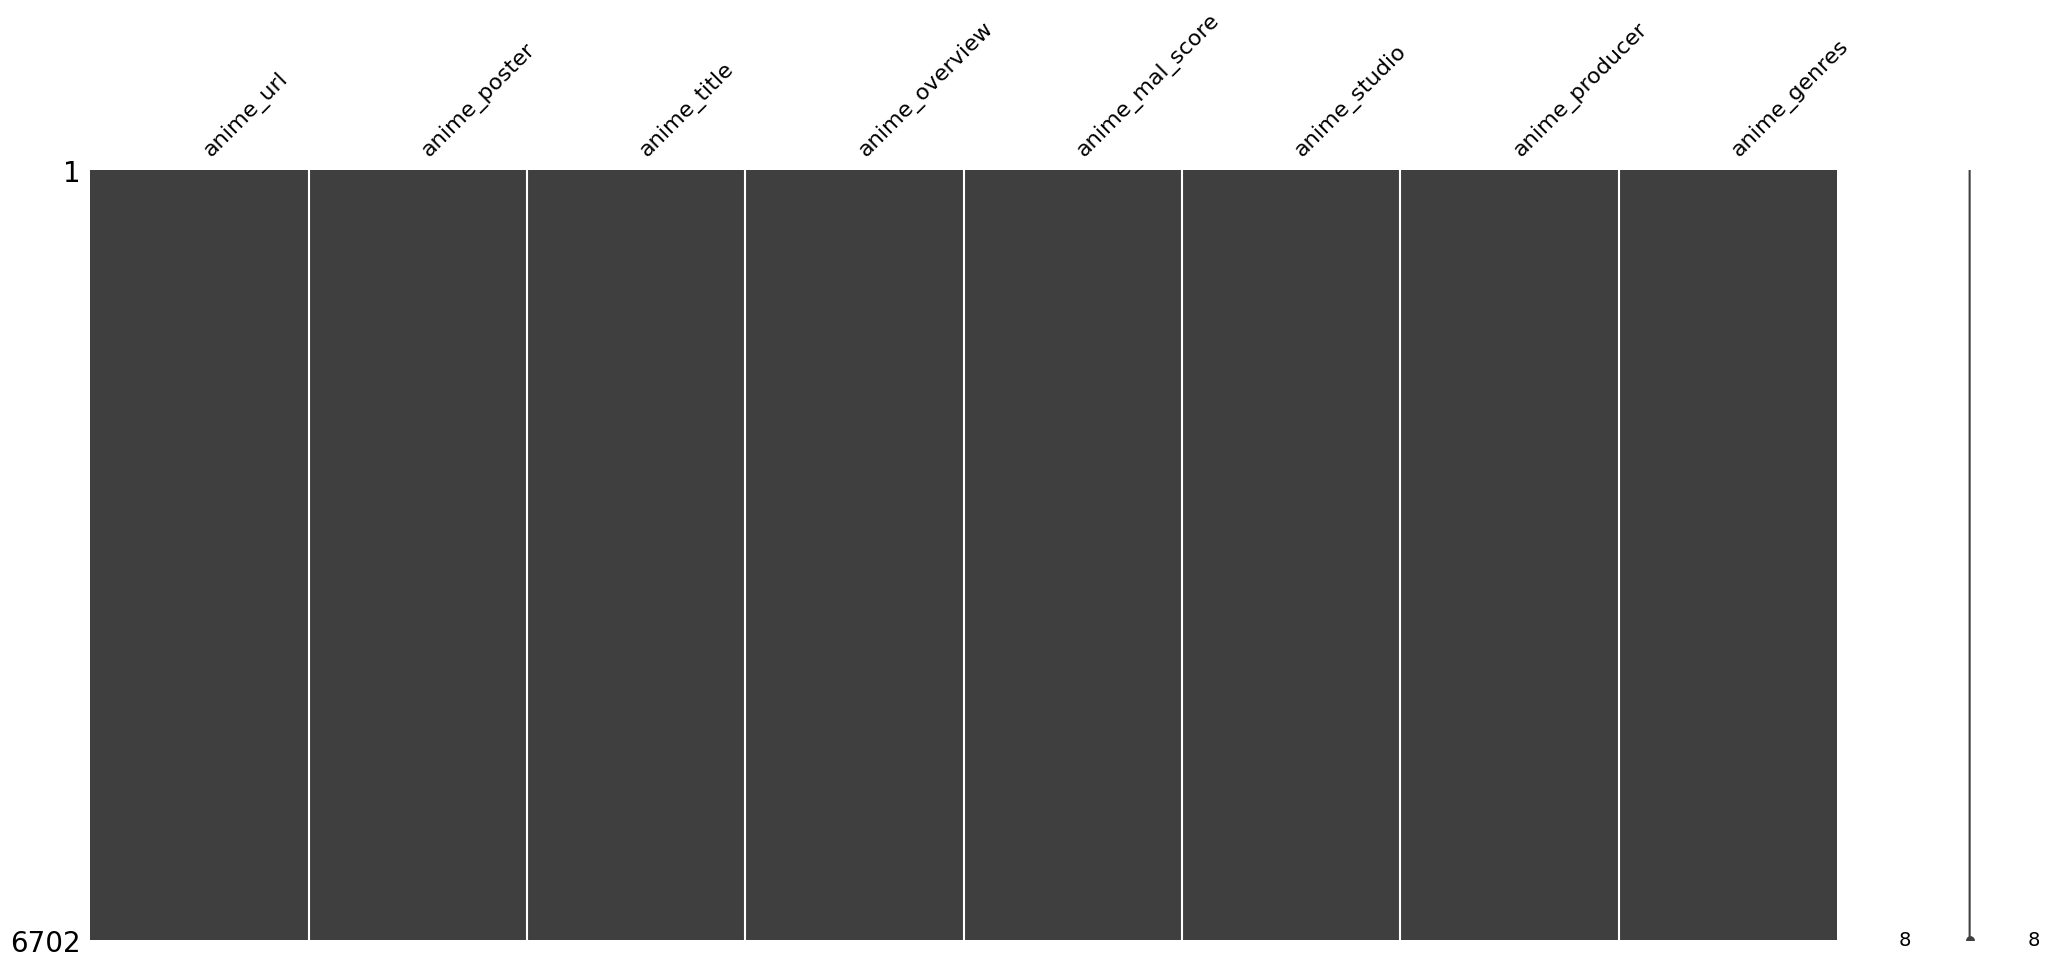

In [6]:
import missingno as msno

msno.matrix(df);

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [8]:
df.anime_genres = df.anime_genres.apply(le)
df.anime_producer = df.anime_producer.apply(le)
df.anime_genres = df.anime_genres.apply(lambda x: [i.replace(" ", "") for i in x])
df.anime_studio = df.anime_studio.apply(lambda x: x.replace(" ", ""))
df.anime_studio = df.anime_studio.apply(lambda x: x.split())

# Text Preprocessing

In [9]:
df['anime_overview'] =  df['anime_overview'].apply(lambda x: x.split(r"[Written by MAL Rewrite]")[0])

# Taking Only Words
df['anime_overview'] = df['anime_overview'].apply(lambda x: " ".join(re.findall(r'[a-zA-Z]+', x)).lower())

# Removing all s and t from the overview which are not in the form of words

df['anime_overview'] = df['anime_overview'].apply(lambda x: re.sub(r'\bs\b|\bt\b','',x))


In [10]:
# Dropping the index column and resetting the index to new values
df.reset_index(drop=True, inplace=True)
df.reset_index(inplace=True)

In [11]:
# Changing the column names
df.rename(
    columns={
        "index": "anime_id",
        "anime_urls": "urls",
        "anime_overview": "overview",
        "anime_genres": "genres",
        "anime_producer": "producer",
        "anime_studio": "studio",
        "anime_mal_score": "score",
        "anime_poster": "poster",
        "anime_title": "title",
    },
    inplace=True,
)

In [12]:
# Making tags as a combination of overview, genres and studio
df.overview = df.overview.astype(str)
df.overview = df.overview.apply(lambda x: x.split())

df['tags'] = df['overview'] + df['genres'] + df['studio']

In [13]:
df['tags'] = df['tags'].apply(lambda x:[i.lower() for i in x])
df['tags'] = df['tags'].apply(lambda x: ' '.join(x))

In [14]:
# Lemmatizing the tags

def stemmer(text):
    doc = nlp(text)
    doc = [token.lemma_ for token in doc if token.lemma_ not in stopwords]
    return ' '.join(doc)

df['tags'] = df['tags'].apply(stemmer)

In [15]:
# CountVectorizer to convert tags into matrix

vectorizer = TfidfVectorizer(analyzer='word',max_features=10000,ngram_range=(1,3),norm='l2')
vector = vectorizer.fit_transform(df['tags']).toarray()
print(vector.shape)

(6702, 10000)


In [16]:
# Cosine similarity

similarity = cosine_similarity(vector)
similarity[0]

array([1.        , 0.12488678, 0.02978093, ..., 0.00206694, 0.0142427 ,
       0.05006359])

In [17]:
def recommend(anime):
    index = df[df['title'] == anime].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])[1:11]
    for i in distances:
        print(df.iloc[i[0]].title)
        pass
    
recommend('Naruto')

Naruto: Shippuden
Naruto: Shippuuden Movie 4 - The Lost Tower
Boruto: Naruto Next Generations
Naruto: Shippuuden Movie 6: Road to Ninja
Boruto: Naruto the Movie
Naruto Shippuuden Movie 3: Inheritors of Will of Fire
Naruto: Shippuuden Movie 5 - Blood Prison
Naruto: Shippuden the Movie 2 -Bonds-
Naruto OVA7: Chunin Exam on Fire! and Naruto vs. Konohamaru!
Naruto OVA2: The Lost Story - Mission: Protect the Waterfall Village


In [18]:
df.to_csv("rec_data.csv", index=False)
pickle.dump(similarity, open(r"D:\Github\Anime-Recommender\similarity.pkl", "wb"))